In [14]:
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt


In [15]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from numpy import sqrt 
import time

#Tien Xu Ly
from sklearn.preprocessing import MinMaxScaler

#Draw Flot
import matplotlib.pyplot as plt

#Cacuale error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

#distance Libaray
from dtw import *
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from scipy.spatial.distance import cityblock

#FFNN, RNN Libarary
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

# ARIMA Libarary
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

#SVR Library
from sklearn.svm import SVR

In [16]:
# Đọc Dữ Liệu
# @param   filePath     Đường dẫn tập dữ liệu CSV
# @return  df           Tập dữ liệu csv dưới dạng df
def readData(filePath):
    # Load dữ liệu
    dataCSV = pd.read_csv(filePath)
    df=dataCSV[['GLD']]
    return df

# Tiền Xử lý Dữ Liệu
# @param  Data   Tập dữ liệu
# @return df     Dữ liệu đã được tiền xử lý
def cleanData(df):
    # Replace null values with 0
    df.fillna(0, inplace=True)
    # Remove outliers by replacing values outside of 10 standard deviations with the mean
    # std = df['GLD'].std()
    # mean = df['GLD'].mean()
    # df['GLD'] = np.where(df['GLD'] > (mean + 10*std), mean, df['GLD'])
    # df['GLD'] = np.where(df['GLD'] < (mean - 10*std), mean, df['GLD'])
    # Scale data_AMZN to range [0, 1]
    scaler = MinMaxScaler()
    df['GLD'] = scaler.fit_transform(df['GLD'].values.reshape(-1, 1))
    # Fill in missing values with the mean of the previous and next values
    df['GLD'] = df['GLD'].interpolate(method='linear')
    return df

# Chia dữ liệu thành train set và test set
# @param  data                      Tập dữ liệu
# @param  percentTrain              Tỷ lệ Tập train
# @return train_data, test_data     Tập train và test   
def splitData(data, percentTrain):
    train_size = int(len(data) * (percentTrain/100))
    train = data.iloc[:train_size, :]
    test = data.iloc[train_size:, :]
    return train, test

# Xử lý dữ liệu thành dữ liệu đầu vào và đầu ra cho mô hình
# @param      data            Dữ liệu cần chia cửa sổ
# @param      size_window     Kích thước cửa sổ
# @param      size_predict    Kích thước cửa sổ dự đoán
# @param      stepWindow      số điểm dữ liệu trượt
# @return     X, y            mảng cửa sổ mẫu và mảng điểm dự đoán tương ứng
def prepare_data(data, size_window, size_predict, stepWindow):
    X, y = [], []
    startWindow = 0
    for i in range(len(data) - size_window - 1):
        if (len(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0]) != size_predict):
            break
        X.append(data[startWindow:(startWindow + size_window), :])
        y.append(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0])
        startWindow += stepWindow
    return np.array(X), np.array(y)

In [17]:
nameData= 'GLD'
filePath= '../data/'+nameData+'.csv'
timeSeries = readData(filePath)
timeSeries = cleanData(timeSeries)
percentTrain = 80
train_data, test_data = splitData(timeSeries, percentTrain)

size_window = 5
size_predict=1
stepWindow=1
X_train, y_train = prepare_data(train_data.values, size_window, size_predict, stepWindow)
X_test, y_test =   prepare_data(test_data.values, size_window, size_predict, stepWindow)

In [18]:
#---------KNN-----------
# Fucntion Tính khoảng cách giữa 2 chuỗi thời gian
# @param    ts1            Chuỗi thứ nhất
# @param    ts2            Chuỗi thứ hai
# @return   euclidean      Khoảng cách euclidean    
def euclidean_distance(ts1, ts2):
    ts1= ts1.flatten()
    ts2= ts2.flatten()
    return euclidean(ts1,ts2)

# Function lấy ra k chuỗi gần nhất
# @param    k             Số lượng chuỗi gần nhất
# @param    distanceArr   Mảng khoảng cách
# @return   argsort       Vị trí chuỗi gần nhất        
def kSimilarityTimeSeries(k, distanceArr):
    distances = np.array(distanceArr)
    return distances.argsort()[:k] 

# Tính khoảng cách DTW
# @param    ts1            Chuỗi thứ nhất
# @param    ts2            Chuỗi thứ hai
# @return   euclidean      Khoảng cách euclidean  
def dtw_dist(ts1, ts2):
    dist, _ = fastdtw(ts1, ts2, dist=cityblock)
    return dist

# Thêm Dữ liệu
# @param    X_train               Cửa sổ mẫu train
# @param    y_train               Cửa sổ dự đoán train
# @param    XTest                 Cửa sổ mẫu test
# @param    yTest                 Cửa sổ dự đoán test
# @return   X_train, y_train      Khoảng cách euclidean 
def toTrain(X_train, y_train, XTest, yTest):
    X_train.append(XTest)
    y_train.append(yTest)
    return np.array(X_train), np.array(y_train)

# Dự đoán Euclidean
# @param    nameData           Tên tập dữ liệu
# @param    k                  Số lượng chuỗi gần nhất
# @param    typeDistance       Độ đo sử dụng (Dtw, euclidean)
# @param    X_train            Cửa sổ mẫu train
# @param    y_train            Cửa sổ dự đoán train
# @param    X_test             Cửa sổ mẫu test
# @param    y_test             Cửa sổ dự đoán test
# @return   y_pred_arr         Mảng dự đoán
def predict_KNN(k, typeDistance, X_train, y_train, X_test, y_test):
    y_pred_arr=[]
    for iTest in range(len(X_test)):
        if(k>len(X_train)):
            k=len(X_train)
        distanceArr=[]
        for iTrain in range(len(X_train)-size_window+2):
            if(typeDistance == 'Dtw'):
                distance = dtw_dist(X_test[iTest],X_train[iTrain])
            else:
                distance = euclidean_distance(X_test[iTest],X_train[iTrain])
            distanceArr.append(distance)
        indexKNN= kSimilarityTimeSeries(k,distanceArr)
        y_pred = np.mean(y_train[indexKNN])
        y_pred_arr.append(y_pred)
        X_train, y_train = toTrain(X_train.tolist(), y_train.tolist(),X_test[iTest].tolist(), y_test[iTest].tolist())
        y_pred = np.array(y_pred_arr)
   
    return y_pred

In [12]:
df_MseWith_K_Euclidean = pd.DataFrame([],  columns =  ["K", "MSE","Time"])
df_MseWith_K_Dtw = pd.DataFrame([],  columns =  ["K", "MSE","Time"])

nameData= 'GLD'
percentTrain = 80
filePath= '../data/'+nameData+'.csv'
timeSeries = readData(filePath)
timeSeries = cleanData(timeSeries)
train_data, test_data = splitData(timeSeries, percentTrain)
for k in range(1,21):
    #Eculidean
    size_window = 5
    size_predict=1
    stepWindow=1
    
    X_train, y_train = prepare_data(train_data.values, size_window, size_predict, stepWindow)
    X_test, y_test =   prepare_data(test_data.values, size_window, size_predict, stepWindow)
    
    start_KNN_Euclidean= time.time()
    y_pred_KNN_Euclidean= predict_KNN(k, 'Euclidean', X_train, y_train, X_test, y_test)
    end_KNN_Euclidean = time.time()
    np.savetxt('../BestParam/KNN/'+nameData+'/KNN_Euclidean_Find_K/'+str(k)+'_K_'+nameData+'.txt', y_pred_KNN_Euclidean)    
    rowMseWithK_Euclidean = pd.DataFrame([[k,mean_squared_error(y_test , y_pred_KNN_Euclidean), (end_KNN_Euclidean - start_KNN_Euclidean)]], columns=df_MseWith_K_Euclidean.columns)
    df_MseWith_K_Euclidean = pd.concat([df_MseWith_K_Euclidean, rowMseWithK_Euclidean],ignore_index=True)

    #Dtw
    X_train, y_train = prepare_data(train_data.values, size_window, size_predict, stepWindow)
    X_test, y_test = prepare_data(test_data.values, size_window, size_predict, stepWindow)
    start_KNN_Dtw= time.time()
    y_pred_KNN_Dtw = predict_KNN(k, 'Dtw', X_train, y_train, X_test, y_test)
    end_KNN_Dtw= time.time()
    np.savetxt('../BestParam/KNN/'+nameData+'/KNN_Dtw_Find_K/'+str(k)+'_K_'+nameData+'.txt', y_pred_KNN_Dtw)    
    rowMseWithK_Dtw = pd.DataFrame([[k, mean_squared_error(y_test , y_pred_KNN_Dtw), (end_KNN_Dtw - start_KNN_Dtw)]], columns=df_MseWith_K_Dtw.columns)
    df_MseWith_K_Dtw = pd.concat([df_MseWith_K_Dtw, rowMseWithK_Dtw],ignore_index=True)

In [99]:
df_MseWith_K_Euclidean_Sort = df_MseWith_K_Euclidean.sort_values('MSE')
best_K_Euclidean=df_MseWith_K_Euclidean_Sort['K'].iloc[0]
# DTW
df_MseWith_K_Dtw_Sort = df_MseWith_K_Dtw.sort_values('MSE')
best_K_Dtw=df_MseWith_K_Dtw_Sort['K'].iloc[0]

In [100]:
df_MseWith_K_Euclidean_Sort

,K,MSE,Time
12,13,0.000096,7.458247
13,14,0.000096,7.375523
14,15,0.000096,7.342361
10,11,0.000096,7.991852
15,16,0.000097,7.425063
16,17,0.000097,9.726559
11,12,0.000097,10.039454
17,18,0.000097,10.161444
18,19,0.000098,8.171840
19,20,0.000098,7.315119


In [101]:
df_MseWith_K_Dtw_Sort

,K,MSE,Time
12,13,0.000093,178.008414
11,12,0.000093,180.414659
10,11,0.000093,170.720419
9,10,0.000093,183.233094
17,18,0.000093,186.755198
19,20,0.000093,165.402301
13,14,0.000093,172.990162
18,19,0.000094,180.289356
8,9,0.000094,178.178054
16,17,0.000094,215.086009


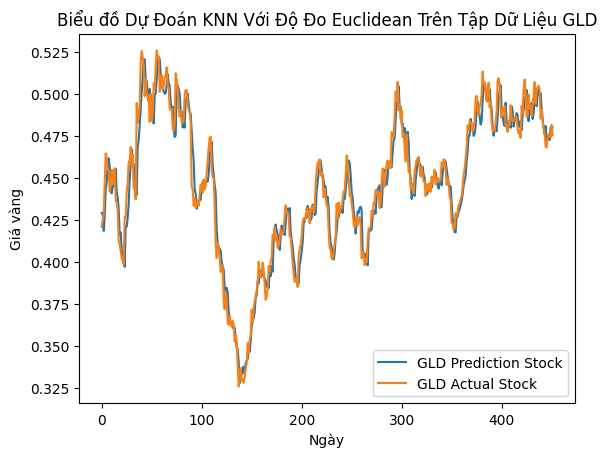

In [104]:
y_pred_KNN_Euclidean= np.loadtxt('../BestParam/KNN/'+nameData+'/KNN_Euclidean_Find_K/'+str(int(best_K_Euclidean))+'_K_'+nameData+'.txt')    
# Vẽ biểu đồ
plt.title("Biểu đồ Dự Đoán KNN Với Độ Đo Euclidean Trên Tập Dữ Liệu "+nameData)
plt.plot(y_pred_KNN_Euclidean, label=nameData+' Prediction Stock')
plt.plot(y_test, label=nameData+' Actual Stock')
plt.xlabel("Ngày")
plt.ylabel("Giá vàng")
plt.legend()
plt.show()

In [105]:
mse_knn_euclidian = mean_squared_error(y_test , y_pred_KNN_Euclidean)
rmse_knn_euclidian = sqrt(mean_squared_error(y_test, y_pred_KNN_Euclidean))
mae_knn_euclidian = mean_absolute_error(y_test,y_pred_KNN_Euclidean)
mape_knn_euclidian = mean_absolute_percentage_error(y_test, y_pred_KNN_Euclidean)

In [106]:
print("MSE Euclidean: " + str(mean_squared_error(y_test , y_pred_KNN_Euclidean)))
print("RMSE Euclidean: " + str(sqrt(mean_squared_error(y_test, y_pred_KNN_Euclidean)) ))
print("MAE Euclidean: " + str(mean_absolute_error(y_test,y_pred_KNN_Euclidean)))
print("MAPE Euclidean: " + str(mean_absolute_percentage_error(y_test, y_pred_KNN_Euclidean)))

MSE Euclidean: 9.554675205852611e-05
RMSE Euclidean: 0.009774801893569307
MAE Euclidean: 0.007245457924216341
MAPE Euclidean: 0.016151935830589565


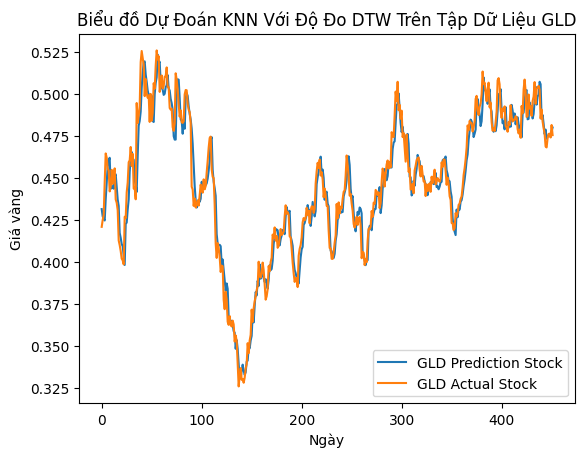

In [25]:
y_pred_KNN_Dtw = np.loadtxt('../BestParam/KNN/'+nameData+'/KNN_Dtw_Find_K/'+str(int(best_K_Dtw))+'_K_'+nameData+'.txt')    
# Vẽ biểu đồ
plt.title("Biểu đồ Dự Đoán KNN Với Độ Đo DTW Trên Tập Dữ Liệu "+nameData)
plt.plot(y_pred_KNN_Dtw, label=nameData+' Prediction Stock')
plt.plot(y_test, label=nameData+' Actual Stock')
plt.xlabel("Ngày")
plt.ylabel("Giá vàng")
plt.legend()
plt.show()

In [96]:
y_pred_KNN_Dtw = np.loadtxt('../BestParam/KNN/'+nameData+'/KNN_Dtw_Find_K/'+str(int(11))+'_K_'+nameData+'.txt')    
y_pred_KNN_Euclidean= np.loadtxt('../BestParam/KNN/'+nameData+'/KNN_Euclidean_Find_K/'+str(int(5))+'_K_'+nameData+'.txt')

In [97]:
mse_knn_dtw = mean_squared_error(y_test , y_pred_KNN_Dtw)
rmse_knn_dtw = sqrt(mean_squared_error(y_test, y_pred_KNN_Dtw))
mae_knn_dtw = mean_absolute_error(y_test,y_pred_KNN_Dtw)
mape_knn_dtw = mean_absolute_percentage_error(y_test, y_pred_KNN_Dtw)

In [98]:
print("MSE Dtw: " + str(mean_squared_error(y_test , y_pred_KNN_Dtw)))
print("RMSE Dtw: " + str(sqrt(mean_squared_error(y_test, y_pred_KNN_Dtw)) ))
print("MAE Dtw: " + str(mean_absolute_error(y_test,y_pred_KNN_Dtw)))
print("MAPE Dtw: " + str(mean_absolute_percentage_error(y_test, y_pred_KNN_Dtw)))

MSE Dtw: 9.296108299605875e-05
RMSE Dtw: 0.009641632797200832
MAE Dtw: 0.007104519910143624
MAPE Dtw: 0.01584641586950264


In [37]:
#----------------FFNN--------------------------
# Khởi tạo mô hình FFNN
# @param    neuralInput         Kích thước Cửa sổ mẫu/ số neural lớp input
# @param    num_layers_hidden   Số lượng lớp ẩn
# @param    num_neural_hidden   Số neural lớp ẩn
# @param    neuralOutput         Số neural lớp ouput
# @return   model               Mô hình FFNN
def create_model_FFNN(neuralInput, num_layers_hidden=1, neuralHidden=1, neuralOutput=1):
    model = Sequential()
    for i in range(num_layers_hidden):
        if i == 0:
            model.add(Dense(neuralHidden, input_dim= neuralInput, activation='sigmoid'))
        else:
            model.add(Dense(neuralHidden, activation='sigmoid'))
    model.add(Dense(neuralOutput))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


# Train FFNN 
# @param    nameData          Tên tập dữ liệu
# @param    size_window       Kích thước Cửa sổ mẫu/ số neural lớp input
# @param    X_train           cửa sổ mẫu tập train
# @param    y_train           Cửa sổ dự đoán tập train
# @param    neuralHidden      Số neural lớp ẩn
# @param    numHiddenLayer    Số lớp ẩn
# @param    size_predict      Kích thước Cửa sổ dự đoán/ Số neural lớp ouput
# @return   best_params_FFNN  Tham số tốt nhất cho mô hình FFNN                
def train_FFNN(nameData, typePredict, size_window, X_train, y_train, neuralHidden, numHiddenLayer, size_predict):
    #param search
    param_grid_FFNN = {'batch_size': [8, 16, 32, 64, 128],
              'epochs': [50, 100, 150, 200, 250, 300],
              'neuralHidden': [neuralHidden],
              'num_layers_hidden' : [numHiddenLayer],
              'neuralInput' : [size_window],
              'neuralOutput' : [size_predict]}

    # create the model
    model_FFNN = KerasRegressor(build_fn=create_model_FFNN, verbose=0)
    
    # perform the grid search
    grid_FFNN = GridSearchCV(estimator=model_FFNN, param_grid=param_grid_FFNN, cv=3)
    grid_result_FFNN = grid_FFNN.fit(X_train, y_train)
    
    # train the model with the best parameters
    best_params_FFNN = grid_result_FFNN.best_params_
    
    model_FFNN = create_model_FFNN( best_params_FFNN['neuralInput'], best_params_FFNN['num_layers_hidden'], best_params_FFNN['neuralHidden'],best_params_FFNN['neuralOutput'])
    model_FFNN.fit(X_train, y_train, epochs=best_params_FFNN['epochs'], batch_size=best_params_FFNN['batch_size'], verbose=2, callbacks=[EarlyStopping(monitor='loss', patience=10)], shuffle=False)
    
    if(typePredict=='FFNN_Find_NeuralHidden'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NeuralHidden/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
    else:
        model_FFNN.save_weights('../BestParam/TuanTu/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
    return best_params_FFNN



# Train FFNN 
# @param    nameData          Tên tập dữ liệu
# @param    size_window       Kích thước Cửa sổ mẫu/ số neural lớp input
# @param    X_train           cửa sổ mẫu tập train
# @param    y_train           Cửa sổ dự đoán tập train
# @param    batchSize         Số lượng mẫu được đưa vào với mỗi lần lặp (epoch)
# @param    epoch             Số lần lặp cập nhật trọng số
# @param    neuralHidden      Số neural lớp ẩn
# @param    numHiddenLayer    Số lớp ẩn
# @param    size_predict      Kích thước Cửa sổ dự đoán/ Số neural lớp ouput
# @return   best_params_FFNN  Tham số tốt nhất cho mô hình FFNN                
def train_best_param_FFNN(nameData, typePredict, size_window, X_train, y_train, batchSize, epoch, neuralHidden, numHiddenLayer, size_predict):
    #param search
    param_grid_FFNN = {'batch_size': batchSize,
              'epochs': epoch,
              'neuralHidden': neuralHidden,
              'num_layers_hidden' : numHiddenLayer,
              'neuralInput' : size_window,
              'neuralOutput' : size_predict}
    
    model_FFNN = create_model_FFNN( param_grid_FFNN['neuralInput'], param_grid_FFNN['num_layers_hidden'], param_grid_FFNN['neuralHidden'],param_grid_FFNN['neuralOutput'])
    model_FFNN.fit(X_train, y_train, epochs=param_grid_FFNN['epochs'], batch_size=param_grid_FFNN['batch_size'], verbose=2, callbacks=[EarlyStopping(monitor='loss', patience=10)], shuffle=False)
    
    if(typePredict=='FFNN_Find_NeuralHidden'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NeuralHidden/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer_SongSong'):
        model_FFNN.save_weights('../BestParam/SongSong/'+nameData+'/FFNN_Find_BestWeights/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
    else:
        model_FFNN.save_weights('../BestParam/TuanTu/'+nameData+'/FFNN_Find_BestWeights/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
   
    return param_grid_FFNN

# Dự Đoán FFNN 
# @param    nameData          Tên tập dữ liệu
# @param    typePredict       Thực hiện loại dự đoán (FFNN_Find_NeuralHidden,FFNN_Find_NumberHiddenLayer,CombinePredict)
# @param    X_train           cửa sổ mẫu tập train
# @param    y_train           Cửa sổ dự đoán tập train
# @param    X_test            Cửa sổ dự đoán tập train
# @param    best_params_FFNN  Cửa sổ dự đoán tập train
# @return   predictions_FFNN  Mảng dự đoán
def predict_FFNN(nameData, typePredict, X_train, y_train, X_test, best_params_FFNN):
    model_FFNN1 = Sequential()
    for i in range(best_params_FFNN['num_layers_hidden']):
        if i == 0:
            model_FFNN1.add(Dense(best_params_FFNN['neuralHidden'], input_dim= best_params_FFNN['neuralInput'], activation='sigmoid'))
        else:
            model_FFNN1.add(Dense(best_params_FFNN['neuralHidden'], activation='sigmoid'))
    model_FFNN1.add(Dense(best_params_FFNN['neuralOutput']))
    
    if(typePredict=='FFNN_Find_NeuralHidden'):
        model_FFNN1.load_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NeuralHidden/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer'):
        model_FFNN1.load_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer_SongSong'):
        model_FFNN1.load_weights('../BestParam/SongSong/'+nameData+'/FFNN_Find_BestWeights/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
    else:
        model_FFNN1.load_weights('../BestParam/TuanTu/'+nameData+'/FFNN_Find_BestWeights/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
   
    model_FFNN1.compile(loss='mean_squared_error', optimizer='adam')
    
    predictions_FFNN = model_FFNN1.predict(X_test)
    return predictions_FFNN

In [38]:
neuralHidden=13
batchSize=32
epoch=200
df_MseWith_HiddenLayer = pd.DataFrame([],  columns =  ["Number Hidden Layer", "Neural Hidden","Batch_Size","Epoch", "MSE","Time Train", "Time Test", "Total Time"])

for numHiddenLayer in range(1,21):
    
    start_Train= time.time()
    best_param = train_best_param_FFNN(nameData, 'FFNN_Find_NumberHiddenLayer', size_window, X_train, y_train, batchSize, epoch, neuralHidden, numHiddenLayer, size_predict)
    end_Train = time.time()
    
    start_Test= time.time()
    predictions_FFNN= predict_FFNN(nameData, 'FFNN_Find_NumberHiddenLayer', X_train, y_train, X_test, best_param)
    end_Test = time.time()

    timeTrain = end_Train - start_Train
    timeTest = end_Test -  start_Test
    totalTime = timeTrain+ timeTest
    
    rowMseWithHiddenLayer = pd.DataFrame([[numHiddenLayer,neuralHidden,best_param['batch_size'],best_param['epochs'], mean_squared_error(y_test , predictions_FFNN), timeTrain, timeTest, totalTime]], columns=df_MseWith_HiddenLayer.columns)
    df_MseWith_HiddenLayer = pd.concat([df_MseWith_HiddenLayer,rowMseWithHiddenLayer],ignore_index=True)

Epoch 1/200
58/58 - 1s - 12ms/step - loss: 0.3907
Epoch 2/200
58/58 - 0s - 1ms/step - loss: 0.0560
Epoch 3/200
58/58 - 0s - 1ms/step - loss: 0.0187
Epoch 4/200
58/58 - 0s - 1ms/step - loss: 0.0171
Epoch 5/200
58/58 - 0s - 1ms/step - loss: 0.0157
Epoch 6/200
58/58 - 0s - 1ms/step - loss: 0.0140
Epoch 7/200
58/58 - 0s - 1ms/step - loss: 0.0122
Epoch 8/200
58/58 - 0s - 902us/step - loss: 0.0106
Epoch 9/200
58/58 - 0s - 1ms/step - loss: 0.0091
Epoch 10/200
58/58 - 0s - 873us/step - loss: 0.0077
Epoch 11/200
58/58 - 0s - 1ms/step - loss: 0.0065
Epoch 12/200
58/58 - 0s - 955us/step - loss: 0.0054
Epoch 13/200
58/58 - 0s - 897us/step - loss: 0.0045
Epoch 14/200
58/58 - 0s - 1ms/step - loss: 0.0037
Epoch 15/200
58/58 - 0s - 876us/step - loss: 0.0031
Epoch 16/200
58/58 - 0s - 1ms/step - loss: 0.0026
Epoch 17/200
58/58 - 0s - 903us/step - loss: 0.0022
Epoch 18/200
58/58 - 0s - 928us/step - loss: 0.0019
Epoch 19/200
58/58 - 0s - 852us/step - loss: 0.0016
Epoch 20/200
58/58 - 0s - 721us/step - los

In [41]:
df_MseWith_HiddenLayer_Sort = df_MseWith_HiddenLayer.sort_values('MSE')
best_NumberHiddenLayer=df_MseWith_HiddenLayer_Sort['Number Hidden Layer'].iloc[0]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


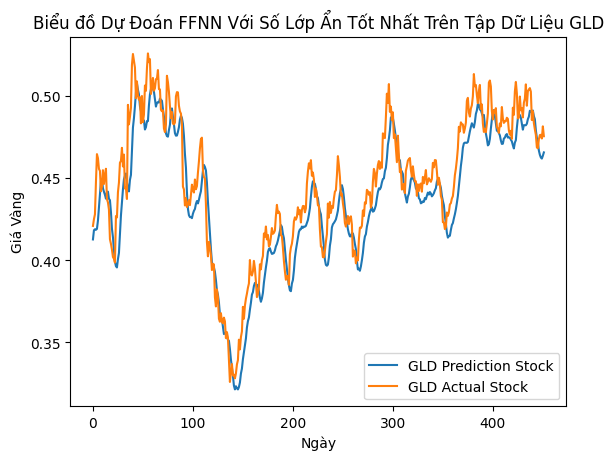

In [42]:
# Vẽ biểu đồ
best_param = {'batch_size': int(df_MseWith_HiddenLayer_Sort['Batch_Size'].iloc[0]),
              'epochs': int(df_MseWith_HiddenLayer_Sort['Epoch'].iloc[0]),
              'neuralHidden': int(df_MseWith_HiddenLayer_Sort['Neural Hidden'].iloc[0]),
              'num_layers_hidden' :int(df_MseWith_HiddenLayer_Sort['Number Hidden Layer'].iloc[0]),
              'neuralInput' : size_window,
              'neuralOutput' : size_predict}
y_pred_FFNN = predict_FFNN(nameData, 'FFNN_Find_NumberHiddenLayer', X_train, y_train, X_test, best_param)

plt.title("Biểu đồ Dự Đoán FFNN Với Số Lớp Ẩn Tốt Nhất Trên Tập Dữ Liệu "+nameData)
plt.plot(y_pred_FFNN, label=nameData+' Prediction Stock')
plt.plot(y_test, label=nameData+' Actual Stock')
plt.xlabel("Ngày")
plt.ylabel("Giá Vàng")
plt.legend()
plt.show()

In [90]:
mse_ffnn = mean_squared_error(y_test , y_pred_FFNN)
rmse_ffnn = sqrt(mean_squared_error(y_test, y_pred_FFNN))
mae_ffnn = mean_absolute_error(y_test,y_pred_FFNN)
mape_ffnn = mean_absolute_percentage_error(y_test, y_pred_FFNN)

In [43]:
print("MSE: " + str(mean_squared_error(y_test , y_pred_FFNN)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, y_pred_FFNN)) ))
print("MAE: " + str(mean_absolute_error(y_test,y_pred_FFNN)))
print("MAPE: " + str(mean_absolute_percentage_error(y_test, y_pred_FFNN)))

MSE: 0.0003020624858223988
RMSE: 0.017379944931512264
MAE: 0.013894105380750123
MAPE: 0.03101778289669277


In [45]:
import os
#----------------RNN--------------------------
def create_model_RNN(neuralInput, num_layers_hidden=1, neuralHidden=50, neuralOutput=1, activation='tanh', optimizer='adam'):
    """
    Creates a Sequential RNN model.

    Parameters:
    - neuralInput (int): Number of input features.
    - num_layers_hidden (int): Number of recurrent hidden layers.
    - neuralHidden (int): Number of neurons in each hidden layer.
    - neuralOutput (int): Number of output neurons.
    - activation (str): Activation function for hidden layers.
    - optimizer (str): Optimizer for compiling the model.

    Returns:
    - model (Sequential): Compiled RNN model.
    """
    model = Sequential()
    for i in range(num_layers_hidden):
        if i == 0:
            model.add(SimpleRNN(neuralHidden, activation=activation, return_sequences=(i < num_layers_hidden - 1), input_shape=(neuralInput, 1)))
        else:
            model.add(SimpleRNN(neuralHidden, activation=activation, return_sequences=(i < num_layers_hidden - 1)))
    model.add(Dense(neuralOutput))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Train RNN with Grid Search
def train_RNN(nameData, typePredict, size_window, X_train, y_train, neuralHidden=50, numHiddenLayer=1, size_predict=1):
    """
    Trains an RNN model using GridSearchCV to find the best hyperparameters.

    Parameters:
    - nameData (str): Name of the dataset.
    - typePredict (str): Type of prediction task.
    - size_window (int): Size of the input window.
    - X_train (array): Training input data.
    - y_train (array): Training target data.
    - neuralHidden (int): Number of neurons in hidden layers.
    - numHiddenLayer (int): Number of hidden layers.
    - size_predict (int): Size of the prediction window.

    Returns:
    - best_params_RNN (dict): Best hyperparameters found.
    """
    # Reshape input data to [samples, timesteps, features]
    X_train_reshaped = X_train.reshape((X_train.shape[0], size_window, 1))

    # Define parameter grid
    param_grid_RNN = {
        'batch_size': [8, 16, 32, 64, 128],
        'epochs': [50, 100, 150, 200, 250, 300],
        'neuralHidden': [neuralHidden],
        'num_layers_hidden': [numHiddenLayer],
        'neuralInput': [size_window],
        'neuralOutput': [size_predict],
        'activation': ['tanh', 'relu'],
        'optimizer': ['adam', 'rmsprop']
    }

    # Create the KerasRegressor
    model_RNN = KerasRegressor(build_fn=create_model_RNN, verbose=0)

    # Initialize GridSearchCV
    grid_RNN = GridSearchCV(estimator=model_RNN, param_grid=param_grid_RNN, cv=3, scoring='neg_mean_squared_error')

    # Perform grid search
    grid_result_RNN = grid_RNN.fit(X_train_reshaped, y_train)

    # Get the best parameters
    best_params_RNN = grid_result_RNN.best_params_

    # Create and train the final model with best parameters
    final_model_RNN = create_model_RNN(
        neuralInput=best_params_RNN['neuralInput'],
        num_layers_hidden=best_params_RNN['num_layers_hidden'],
        neuralHidden=best_params_RNN['neuralHidden'],
        neuralOutput=best_params_RNN['neuralOutput'],
        activation=best_params_RNN['activation'],
        optimizer=best_params_RNN['optimizer']
    )

    final_model_RNN.fit(
        X_train_reshaped, y_train,
        epochs=best_params_RNN['epochs'],
        batch_size=best_params_RNN['batch_size'],
        verbose=2,
        callbacks=[EarlyStopping(monitor='loss', patience=10)],
        shuffle=False
    )

    # Define the path to save weights
    save_path = f'../BestParam/RNN/{nameData}/{typePredict}/'
    os.makedirs(save_path, exist_ok=True)
    weight_filename = f"{best_params_RNN['num_layers_hidden']}_HiddenLayer_" \
                      f"{best_params_RNN['neuralHidden']}_NeuralHidden_" \
                      f"{best_params_RNN['batch_size']}_BatchSize_" \
                      f"{best_params_RNN['epochs']}_Epoch_{nameData}.weights.h5"
    final_model_RNN.save_weights(os.path.join(save_path, weight_filename))

    return best_params_RNN



# Train RNN with Specific Parameters
def train_best_param_RNN(nameData, typePredict, size_window, X_train, y_train, batchSize, epoch, neuralHidden, numHiddenLayer, size_predict, activation='relu', optimizer='adam'):
    # Set up parameter grid with lists
    param_grid_RNN = {
        'batch_size': [batchSize],
        'epochs': [epoch],
        'neuralHidden': [neuralHidden],
        'num_layers_hidden': [numHiddenLayer],
        'neuralInput': [size_window],
        'neuralOutput': [size_predict],
        'activation': [activation],
        'optimizer': [optimizer]
    }
    
    # Extract the best parameters directly from the dictionary
    best_params_RNN = {
        'batch_size': param_grid_RNN['batch_size'][0],
        'epochs': param_grid_RNN['epochs'][0],
        'neuralHidden': param_grid_RNN['neuralHidden'][0],
        'num_layers_hidden': param_grid_RNN['num_layers_hidden'][0],
        'neuralInput': param_grid_RNN['neuralInput'][0],
        'neuralOutput': param_grid_RNN['neuralOutput'][0],
        'activation': param_grid_RNN['activation'][0],
        'optimizer': param_grid_RNN['optimizer'][0]
    }
    
    # Create and train the RNN model
    model_RNN = create_model_RNN(
        neuralInput=best_params_RNN['neuralInput'],
        num_layers_hidden=best_params_RNN['num_layers_hidden'],
        neuralHidden=best_params_RNN['neuralHidden'],
        neuralOutput=best_params_RNN['neuralOutput'],
        activation=best_params_RNN['activation'],
        optimizer=best_params_RNN['optimizer']
    )
    
    # Train the model
    model_RNN.fit(
        X_train, y_train,
        epochs=best_params_RNN['epochs'],
        batch_size=best_params_RNN['batch_size'],
        verbose=2,
        callbacks=[EarlyStopping(monitor='loss', patience=10)],
        shuffle=False
    )

    # Save model weights based on type of prediction
    if typePredict == 'RNN_Find_NumberHiddenLayer':
        model_RNN.save_weights(f'../BestParam/RNN/{nameData}/RNN_Find_NumberHiddenLayer/{numHiddenLayer}_HiddenLayer_{neuralHidden}_NeuralHidden_{batchSize}_BatchSize_{epoch}_Epoch_{nameData}.weights.h5')
    # Add any other conditions as needed for saving

    return best_params_RNN

# Predict with the Trained RNN
def predict_RNN(nameData, typePredict, X_train, y_train, X_test, best_params_RNN):
    """
    Makes predictions using the trained RNN model.

    Parameters:
    - nameData (str): Name of the dataset.
    - typePredict (str): Type of prediction task.
    - X_train (array): Training input data.
    - y_train (array): Training target data.
    - X_test (array): Test input data.
    - best_params_RNN (dict): Best hyperparameters for the model.

    Returns:
    - predictions_RNN (array): Predicted values.
    """
    # Reshape input data to [samples, timesteps, features]
    X_test_reshaped = X_test.reshape((X_test.shape[0], best_params_RNN['neuralInput'], 1))

    # Recreate the model architecture
    model_RNN = create_model_RNN(
        neuralInput=best_params_RNN['neuralInput'],
        num_layers_hidden=best_params_RNN['num_layers_hidden'],
        neuralHidden=best_params_RNN['neuralHidden'],
        neuralOutput=best_params_RNN['neuralOutput'],
        activation=best_params_RNN['activation'],
        optimizer=best_params_RNN['optimizer']
    )

    # Define the path to load weights
    weight_filename = f"{best_params_RNN['num_layers_hidden']}_HiddenLayer_" \
                      f"{best_params_RNN['neuralHidden']}_NeuralHidden_" \
                      f"{best_params_RNN['batch_size']}_BatchSize_" \
                      f"{best_params_RNN['epochs']}_Epoch_{nameData}.weights.h5"

    weight_path = f'../BestParam/RNN/{nameData}/{typePredict}/{weight_filename}'

    if not os.path.exists(weight_path):
        raise FileNotFoundError(f"Weight file not found at {weight_path}")

    # Load the saved weights
    model_RNN.load_weights(weight_path)

    # Compile the model
    model_RNN.compile(loss='mean_squared_error', optimizer=best_params_RNN['optimizer'])

    # Make predictions
    predictions_RNN = model_RNN.predict(X_test_reshaped)

    return predictions_RNN

In [46]:
# Initialize DataFrame to store results
df_MseWith_HiddenLayer_RNN = pd.DataFrame(columns=["Number Hidden Layer", "Neural Hidden", "Batch Size", "Epoch", "MSE", "Time Train", "Time Test", "Total Time"])

# Loop through hidden layers and train model
for numHiddenLayer in range(1, 21):
    start_train = time.time()
    
    # Train RNN model
    best_param = train_best_param_RNN(nameData, 'RNN_Find_NumberHiddenLayer', size_window, X_train, y_train, batchSize, epoch, neuralHidden, numHiddenLayer, size_predict)
    end_train = time.time()
    
    # Make predictions
    start_test = time.time()
    predictions_RNN = predict_RNN(nameData, 'RNN_Find_NumberHiddenLayer', X_train, y_train, X_test, best_param)
    end_test = time.time()
    
    # Calculate timing and performance metrics
    time_train = end_train - start_train
    time_test = end_test - start_test
    total_time = time_train + time_test
    mse = mean_squared_error(y_test, predictions_RNN)
    
    # Append results to DataFrame
    row_mse_with_hidden_layer = pd.DataFrame([[numHiddenLayer, neuralHidden, best_param['batch_size'], best_param['epochs'], mse, time_train, time_test, total_time]], 
                                             columns=df_MseWith_HiddenLayer_RNN.columns)
    df_MseWith_HiddenLayer_RNN = pd.concat([df_MseWith_HiddenLayer_RNN, row_mse_with_hidden_layer], ignore_index=True)

Epoch 1/200
58/58 - 1s - 20ms/step - loss: 0.4626
Epoch 2/200
58/58 - 0s - 3ms/step - loss: 0.0293
Epoch 3/200
58/58 - 0s - 3ms/step - loss: 0.0120
Epoch 4/200
58/58 - 0s - 2ms/step - loss: 0.0086
Epoch 5/200
58/58 - 0s - 2ms/step - loss: 0.0051
Epoch 6/200
58/58 - 0s - 1ms/step - loss: 0.0030
Epoch 7/200
58/58 - 0s - 2ms/step - loss: 0.0020
Epoch 8/200
58/58 - 0s - 1ms/step - loss: 0.0016
Epoch 9/200
58/58 - 0s - 2ms/step - loss: 0.0014
Epoch 10/200
58/58 - 0s - 2ms/step - loss: 0.0013
Epoch 11/200
58/58 - 0s - 2ms/step - loss: 0.0013
Epoch 12/200
58/58 - 0s - 2ms/step - loss: 0.0012
Epoch 13/200
58/58 - 0s - 2ms/step - loss: 0.0012
Epoch 14/200
58/58 - 0s - 3ms/step - loss: 0.0012
Epoch 15/200
58/58 - 0s - 1ms/step - loss: 0.0012
Epoch 16/200
58/58 - 0s - 2ms/step - loss: 0.0011
Epoch 17/200
58/58 - 0s - 2ms/step - loss: 0.0011
Epoch 18/200
58/58 - 0s - 1ms/step - loss: 9.4859e-04
Epoch 19/200
58/58 - 0s - 2ms/step - loss: 8.9777e-04
Epoch 20/200
58/58 - 0s - 2ms/step - loss: 8.9272e

In [47]:
df_MseWith_HiddenLayer_RNN_Sort = df_MseWith_HiddenLayer_RNN.sort_values('MSE')
best_NumberHiddenLayer=df_MseWith_HiddenLayer_RNN_Sort['Number Hidden Layer'].iloc[0]

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


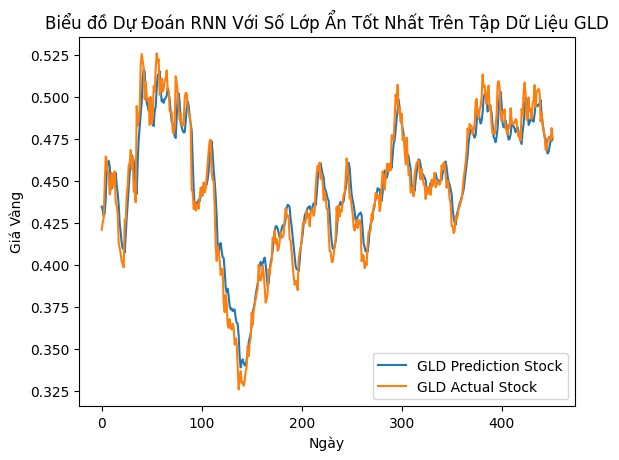

In [48]:
# Vẽ biểu đồ
best_param = {
    'batch_size': int(df_MseWith_HiddenLayer_RNN_Sort['Batch Size'].iloc[0]),
    'epochs': int(df_MseWith_HiddenLayer_RNN_Sort['Epoch'].iloc[0]),
    'neuralHidden': int(df_MseWith_HiddenLayer_RNN_Sort['Neural Hidden'].iloc[0]),
    'num_layers_hidden': int(df_MseWith_HiddenLayer_RNN_Sort['Number Hidden Layer'].iloc[0]),
    'neuralInput': size_window,
    'neuralOutput': size_predict,
    'activation': 'relu',  # Set a default value, like 'relu'
    'optimizer': 'adam'    # Set a default value, like 'adam'
}

y_pred_RNN= predict_RNN(nameData, 'RNN_Find_NumberHiddenLayer', X_train, y_train, X_test, best_param)

plt.title("Biểu đồ Dự Đoán RNN Với Số Lớp Ẩn Tốt Nhất Trên Tập Dữ Liệu "+nameData)
plt.plot(y_pred_RNN, label=nameData+' Prediction Stock')
plt.plot(y_test, label=nameData+' Actual Stock')
plt.xlabel("Ngày")
plt.ylabel("Giá Vàng")
plt.legend()
plt.show()

In [49]:
print("MSE: " + str(mean_squared_error(y_test , y_pred_RNN)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, y_pred_RNN)) ))
print("MAE: " + str(mean_absolute_error(y_test,y_pred_RNN)))
print("MAPE: " + str(mean_absolute_percentage_error(y_test, y_pred_RNN)))

MSE: 0.00011307974449241132
RMSE: 0.010633896016625859
MAE: 0.008079034228877048
MAPE: 0.01832639957743272


In [88]:
mse_rnn = mean_squared_error(y_test , y_pred_RNN)
rmse_rnn = sqrt(mean_squared_error(y_test, y_pred_RNN))
mae_rnn = mean_absolute_error(y_test,y_pred_RNN)
mape_rnn = mean_absolute_percentage_error(y_test, y_pred_RNN)

In [52]:
param_grid_arima = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.05, 0.1, 0.5],
    'gamma': ['scale', 'auto', 0.1, 0.5, 1],
    'kernel': ['linear', 'rbf', 'sigmoid']
}

# Perform Grid Search with 5-fold Cross-Validation
grid_search_arima = GridSearchCV(estimator=SVR(), param_grid=param_grid_arima, 
                           scoring='neg_mean_squared_error', cv=5, verbose=2)

In [53]:
# Fit the model to the training data
grid_search_arima.fit(X_train.reshape(X_train.shape[0], -1), y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END ....C=0.1, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, epsilon=0.01, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ...C=0.1, epsilon=0.01, gamma=scale,

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'epsilon': [0.01, 0.05, 0.1, 0.5],
                         'gamma': ['scale', 'auto', 0.1, 0.5, 1],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=2)

In [54]:
# Display the best parameters
print(f"Best parameters found: {grid_search_arima.best_params_}")

Best parameters found: {'C': 10, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear'}


In [65]:



# Find the best parameters using auto_arima on the scaled training data
auto_arima_model = pm.auto_arima(train_data['GLD'], 
                                 start_p=1, start_q=1,
                                 max_p=5, max_q=5,
                                 start_d=0, max_d=5,
                                 seasonal=False,
                                 trace=True,
                                 stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10333.828, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10332.406, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10333.371, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10333.274, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10334.174, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.870 seconds


In [66]:
print(auto_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1832
Model:               SARIMAX(0, 1, 0)   Log Likelihood                5168.087
Date:                Sun, 03 Nov 2024   AIC                         -10334.174
Time:                        19:13:16   BIC                         -10328.662
Sample:                             0   HQIC                        -10332.141
                               - 1832                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0002   2.38e-06     87.018      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   2.97   Jarque-Bera (JB):             16704.07
Prob(Q):                              0.08   Pr

In [74]:
y_pred_arima = []
history = list(train_data['GLD'])  # Ensure `history` is a 1D list of values

for t in range(len(test_data['GLD'])):
    # Ensure `history` is correctly formatted as a 1D array
    model = ARIMA(history, order=(0, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    y_pred_arima.append(output[0])  # Store only the forecasted value
    history.append(test_data['GLD'].iloc[t])  # Update history with observed value

In [93]:
mse_arima = mean_squared_error(test_data['GLD'] , y_pred_arima)
rmse_arima = sqrt(mean_squared_error(test_data['GLD'], y_pred_arima))
mae_arima = mean_absolute_error(test_data['GLD'],y_pred_arima)
mape_arima = mean_absolute_percentage_error(test_data['GLD'], y_pred_arima)

In [76]:
print("MSE: " + str(mean_squared_error(test_data['GLD'] , y_pred_arima)))
print("RMSE: " + str(sqrt(mean_squared_error(test_data['GLD'], y_pred_arima)) ))
print("MAE: " + str(mean_absolute_error(test_data['GLD'],y_pred_arima)))
print("MAPE: " + str(mean_absolute_percentage_error(test_data['GLD'], y_pred_arima)))

MSE: 7.446076720894265e-05
RMSE: 0.00862906525696397
MAE: 0.006378658537800088
MAPE: 0.014293288748458349


In [77]:
# SVR model
model_svr = SVR(kernel='linear', gamma= 'scale', C=10, epsilon=0.01)

# Fit the model
model_svr.fit(X_train.reshape(X_train.shape[0], -1), y_train)

SVR(C=10, epsilon=0.01, kernel='linear')

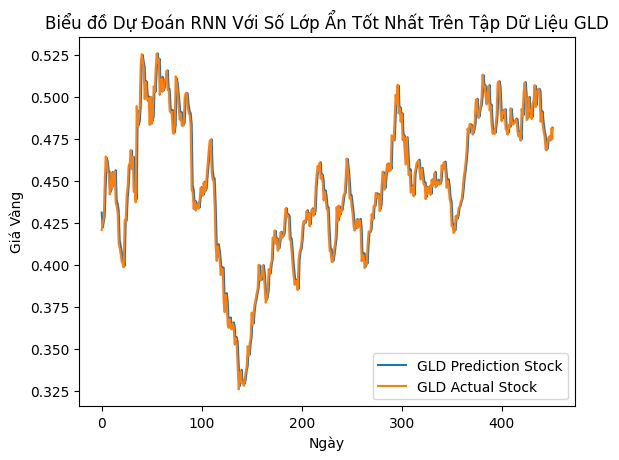

In [ ]:
# Make predictions
y_pred_svr = model_svr.predict(X_test.reshape(X_test.shape[0], -1))

plt.title("Biểu đồ Dự Đoán SVR Với Số Lớp Ẩn Tốt Nhất Trên Tập Dữ Liệu "+nameData)
plt.plot(y_pred_svr, label=nameData+' Prediction Stock')
plt.plot(y_test, label=nameData+' Actual Stock')
plt.xlabel("Ngày")
plt.ylabel("Giá Vàng")
plt.legend()
plt.show()

In [94]:
mse_svr = mean_squared_error(y_test , y_pred_svr)
rmse_svr = sqrt(mean_squared_error(y_test, y_pred_svr))
mae_svr = mean_absolute_error(y_test,y_pred_svr)
mape_svr = mean_absolute_percentage_error(y_test, y_pred_svr)

In [80]:
print("MSE: " + str(mean_squared_error(y_test , y_pred_svr)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, y_pred_svr)) ))
print("MAE: " + str(mean_absolute_error(y_test, y_pred_svr)))
print("MAPE: " + str(mean_absolute_percentage_error(y_test, y_pred_svr)))

MSE: 7.399601086326797e-05
RMSE: 0.008602093400054894
MAE: 0.006337735707403638
MAPE: 0.014207597852618263


In [107]:
# Tạo bảng sai số
error_table = pd.DataFrame({
    'Model': ['SVR', 'ARIMA', 'RNN', 'KNN', 'FFNN'],
    'MSE': [mse_svr, mse_arima, mse_rnn, mse_knn_dtw, mse_ffnn],
    'RMSE': [rmse_svr, rmse_arima, rmse_rnn, rmse_knn_dtw, rmse_ffnn],
    'MAE': [mae_svr, mae_arima, mae_rnn, mae_knn_dtw, mae_ffnn],
    'MAPE': [mape_svr, mape_arima, mape_rnn, mape_knn_dtw, mape_ffnn]
})

print(error_table)

   Model       MSE      RMSE       MAE      MAPE
0    SVR  0.000074  0.008602  0.006338  0.014208
1  ARIMA  0.000074  0.008629  0.006379  0.014293
2    RNN  0.000113  0.010634  0.008079  0.018326
3    KNN  0.000093  0.009642  0.007105  0.015846
4   FFNN  0.000302  0.017380  0.013894  0.031018
